ABT-2 <br>
Выполнила: Голикова Софья

1. [Предварительный анализ](#preliminary_analysis)
2. Исследование метрик
    1. [Среднее значение metric_value](#metric_value)
    2. [Среднее количество сессий](#sessions_num)
    3. [Отток пользователей](#churn_ratio)
3. [Расчет необходимого объема выборок](#sample_size)
4. [Общий вывод](#conclusion)

<a name="preliminary_analysis"></a>
#Предварительный анализ

На сайте проводится эксперимент. Время проведения эксперимента
– 2 недели. <br>
Всего на сайте DAU около 500 000 и WAU около 850 000. Всего за
время работы на сайте образовалась аудитория из около 1 500 000 не
уходящих в отток посетителей. <br>
Необходимо по имеющимся данным исследовать, какие позитивные и негативные эффекты вызвало нововведение. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn_qqplot import pplot
from scipy.stats import norm

In [ ]:
buckets = pd.read_csv('gdrive/MyDrive/Colab Notebooks/abt2_data/hw_abt_2_bybucket.csv', 
                      delimiter='\t')
users = pd.read_csv('gdrive/MyDrive/Colab Notebooks/abt2_data/hw_abt_2_byuser.csv', 
                    delimiter='\t', index_col=0)

Колонки в таблицах:
- group_id - bucket’ы с номерами от 1 до 16. К группе ‘A’, контрольной, относятся bucket’ы 1..8, к группе ‘B’, экспериментальной, – 9..16;
- metric_value – сумма целевых действий пользователей в рамках bucket’а –
например, просмотров рекламного баннера, телефона на сайте classified-сервиса
или покупок в retail/FMCG;
- users – кол-во пользователей, совершивших целевое действие;
- visits – кол-во целевых сессий (закончившихся успешным целевым действием);
- churn_users – кол-во пользователей в рамках bucket’а, отказавшихся
сделать заказ или ушедших в отток во время эксперимента;
- churn_visits – количество сессий, не закончившихся успешным целевым действием.

In [ ]:
buckets

,group_id,metric_value,users,visits,churn_users,churn_visits
0,1,1875345.000,155,1419,151,2207
1,2,1662237.000,138,1320,127,1853
2,3,1784372.000,128,1281,159,2032
3,4,1876826.000,163,1644,168,2172
4,5,1913180.000,156,1675,174,2273
5,6,1733079.000,144,1509,141,2009
6,7,1864555.000,151,1481,161,2139
7,8,2029143.000,162,1533,153,2299
8,9,2047289.536,143,1424,242,2191
9,10,2228154.648,179,1803,265,2518


In [ ]:
users.head(10)

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B
5,2,8539.000,0,0,0,8,A
6,8,5714.000,0,0,0,7,A
7,3,7330.000,0,0,0,6,A
8,2,6759.000,1,4,1,7,A
9,12,6963.976,1,1,0,6,B


В таблице пользователей сразу бросается в глаза ситуация, когда visits = 0, а metric_value > 0. То есть, у этих пользователей не было успешных целевых сессий, однако metric_value для них не равно 0. Есть несколько предположений по этому поводу: <br><br>
**Версия 1**: для каждого пользователя сохранилась история его недавних успешных действий, но во время эксперимента успешных целевых сессий не было. <br>
**Версия 2**: во время проведения эксперимента пользователь отказался от уже оплаченного заказа, но средства были возвращены после окончания эксперимента. <br>
**Версия 3**: у пользователя есть подписка на услуги, предоставляемые сайтом, и ему не обязательно заходить на сайт, чтобы увеличивалось metric_value. <br>
**Версия 4: успешность сессии может определяться последним действием пользователя, тогда пользователь за одну и ту же сессию может сначала совершить целевое действие (сделать заказ), а потом отказаться от выполнения целевого действия (отменить другой созданный заказ).** <br><br>

Первые 3 версии подходят, если ситуация "visits = 0, metric_value > 0" характерна для небольшой части пользователей, т.к. эти версии достаточно специфичны (например, подписку обычно имеет не очень большая доля пользователей, а возврат денежных средств только после окончания эксперимента свойственен пользователям, отменившим заказ в последние дни эксперимента). <br><br>
4 версия выглядит более обычной и типичной для большой части пользователей, а, как мы можем убедиться, 2758 пользователей (больше половины) имеют visits = 0 при metric_value > 0. Поэтому в дальнейшем будем придерживаться этой версии.

In [ ]:
print('Number of users with visits = 0 and metric_value > 0: ', 
      users.loc[(users['visits'] == 0) & (users['metric_value'] != 0)].shape[0], 
      sep='')

Number of users with visits = 0 and metric_value > 0: 2758


Также поясним некоторые не совсем очевидные моменты (на основе предположений и допущений): <br>
- visits = 0, users != 0 - пользователь только создал аккаунт либо перекрыл успешное действие неуспешным во время сессии (см. версию 4 выше) 
- churn_visits = 0, churn_users != 0 - пользователь удалил аккаунт сразу после создания (в той же сессии)
- churn_visits != 0, churn_users = 0 - пользователь не ушел в отток, но периодически совершает неудачные действия

Размеры выборок:

In [ ]:
print('Group A size: {}'.format(users.loc[users['group'] == 'A'].shape[0]))
print('Group B size: {}'.format(users.loc[users['group'] == 'B'].shape[0]))
print('Size ratio: {}'.format(users.loc[users['group'] == 'A'].shape[0] / 
                              users.loc[users['group'] == 'B'].shape[0]))

Group A size: 2451
Group B size: 2549
Size ratio: 0.9615535504119262


Метрики, которые мы будем исследовать при сравнении групп A и B:
1. Среднее значение metric_value
2. Среднее количество сессий (и удачных, и неудачных)
3. Отток пользователей - доля churn_users

Можно было бы рассмотреть metric_value per session, но в таблице много записей с visits = 0 при metric_value > 0 (мы рассмотрели эту ситуацию ранее и остановились на версии, что успешность сессии может определяться последним действием, и тогда неудачное действие может "перекрывать" удачное). Таким образом, мы не можем однозначно определить количество успешных сессий и исследовать данную метрику.

<a name="metric_value"></a>
#Среднее значение metric_value

**Нулевая гипотеза**: <br>
H0 - раличия в средних значениях metric_value для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между средними значениями metric_value для групп A и B действительно существуют значимые различия

In [ ]:
metric_group_a = users.loc[users['group'] == 'A']['metric_value']
metric_group_b = users.loc[users['group'] == 'B']['metric_value']

In [ ]:
print('Group A Metric Value mean: ', metric_group_a.mean(), sep='')
print('Group B Metric Value mean: ', metric_group_b.mean(), sep='')

Group A Metric Value mean: 6013.356589147287
Group B Metric Value mean: 6446.181178501194


In [ ]:
lift = (metric_group_b.mean() / metric_group_a.mean() - 1) * 100
print('Lift: {:.2}%'.format(lift))

Lift: 7.2%


Распределения metric_value для каждой из групп:

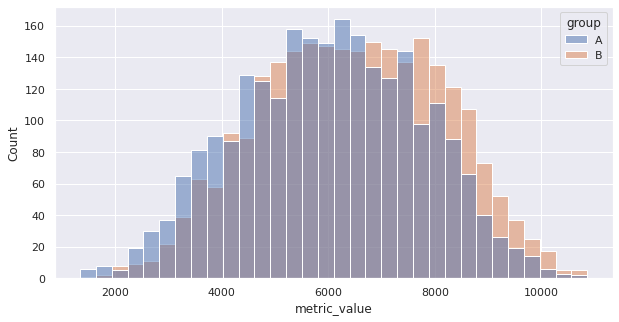

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=users, x="metric_value", hue='group')
plt.show()

Диаграммы размаха:

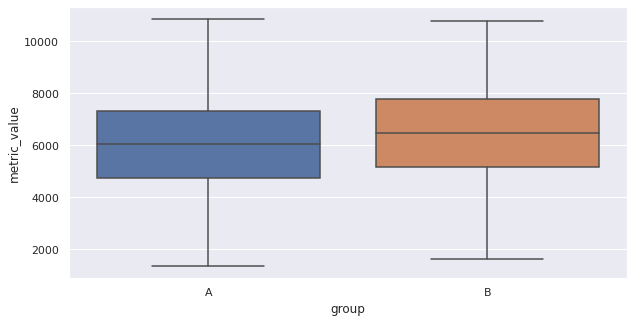

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

sns.boxplot(x='group', y='metric_value', data=users)
plt.show()

###Проверка распределений на нормальность

**H0**: распределение является нормальным <br>
**H1**: распределение не является нормальным

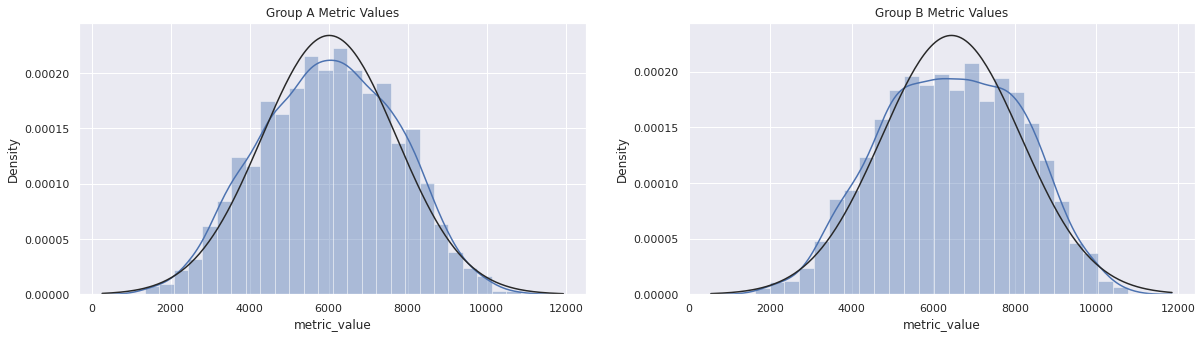

In [ ]:
sns.set(rc={'figure.figsize':(20, 5)})
fig, ax = plt.subplots(1, 2)

sns.distplot(metric_group_a, fit=norm, ax=ax[0])
ax[0].set_title('Group A Metric Values')
sns.distplot(metric_group_b, fit=norm, ax=ax[1])
ax[1].set_title('Group B Metric Values')

fig.show()

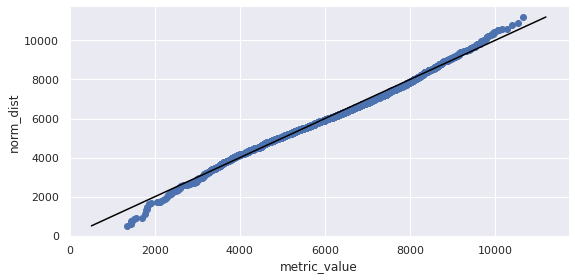

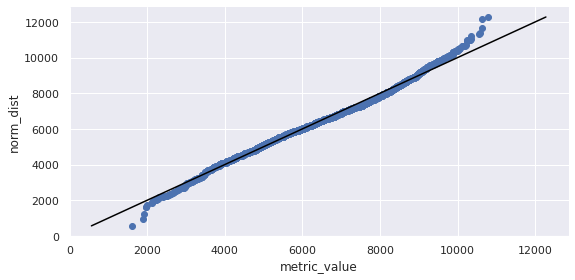

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

tmp_a = pd.DataFrame(metric_group_a)
pplot(tmp_a, x='metric_value', y=norm, kind='qq', height=4, aspect=2, 
      display_kws={'identity':True})

tmp_b = pd.DataFrame(metric_group_b)
pplot(tmp_b, x='metric_value', y=norm, kind='qq', height=4, aspect=2, 
      display_kws={'identity':True})

plt.show()

Визуально распределения напоминают нормальные, но с небольшими отклонениями.<br>
Проведем формальный тест, чтобы это доказать или опровергнуть.

Воспользуемся **критерием Колмогорова-Смирнова** для проверки распределений на нормальность. <br>
Используем данный критерий, т.к. размеры наших выборок велики, а данный критерий как раз подходит для больших объемов выборок.<br>

In [ ]:
# normal distributions with the parameters of our data

loc_a, scale_a = metric_group_a.mean(), metric_group_a.std()
loc_b, scale_b = metric_group_b.mean(), metric_group_b.std()

norm_a = norm(loc=loc_a, scale=scale_a)
norm_b = norm(loc=loc_b, scale=scale_b)

In [ ]:
from scipy.stats import kstest

alpha = 0.05

p_value = kstest(metric_group_a, norm_a.cdf)[1]

print('Distribution A is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha], 
             p_value))

p_value = kstest(metric_group_b, norm_b.cdf)[1]

print('Distribution B is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha], p_value))

Distribution A is normal (p-value = 0.07205853374498336)
Distribution B is not normal (p-value = 0.0013556382971441077)


На основе полученных значений p-value мы можем **отвергнуть нулевую гипотезу о нормальном распределении для группы B** и **не можем отвергнуть ее для группы A**, т.е. распределение A соответсвует нормальному закону распределения, а распределение B - нет. 

###Проверка равенства дисперсий

**H0**: Var(X1) = Var(X2) <br>
**H1**: Var(X1) != Var(X2)

В качестве критерия однородности используем критерий Левена, т.к. он менее чувствителен к отклонению распределения от нормального, чем другие критерии однородности (такие как F-критерий Фишера или критерий Бартлетта).

In [ ]:
from scipy.stats import levene
 
alpha = 0.05 

p_value = levene(metric_group_a, metric_group_b)[1] 

print('{} the H0: Var(X1) = Var(X2) (p-value = {})\n'.
      format({True:'Reject', False:'Confirm'}[p_value < alpha], p_value))

Confirm the H0: Var(X1) = Var(X2) (p-value = 0.35494527384691044)



На основании полученного значения p-value мы **не можем отвергнуть нулевую гипотезу H0** о равенстве дисперсий групп A и B.

###Проверка статистической значимости различий 

Воспользуемся **T-критерием Стьюдента для независимых выборок**. <br>
Это параметрический критерий, т.е. требует соответствия распределения каждой выборки нормальному. Также требованием является равенство дисперсий. По результатам критерия Колмогорова-Смирнова мы получили, что одна из выборок не является нормально распределенной (p-value = 0.001), однако визуально (на графиках распределений и qq-plot) оба распределения похожи на нормальные.<br>

In [ ]:
from scipy.stats import ttest_ind

alpha = 0.05

p_value = ttest_ind(metric_group_a, metric_group_b)[1]
 
print('Diffs is {}significant (p-value = {})\n'.
      format({False:'not ', True:''}[p_value < alpha], p_value)) 

Diffs is significant (p-value = 5.219043548940759e-19)



Мы **отвергаем нулевую гипотезу** и таким образом получаем, что между средними значениями metric_value для групп A и B действительно существуют значимые различия. <br><br>
Средняя сумма целевых действий пользователей в экспериментальной группе больше по сравнению с контрольной, то есть **нововведение имело положительный эффект в плане увеличения среднего показателя metric_value**.

<a name="sessions_num"></a>
#Среднее количество сессий

**Нулевая гипотеза**: <br>
H0 - различия в средних количествах сессий для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между средними количествами сессий для групп A и B действительно существуют значимые различия

Создадим в таблице дополнительную колонку с общим количеством сессий для каждого пользователя:

In [ ]:
users['total_visits'] = users['churn_visits'] + users['visits']
users.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group,total_visits
0,8,6630.000,0,0,0,8,A,8
1,13,6933.976,0,0,1,6,B,6
2,10,8261.976,1,10,1,8,B,18
3,4,5522.000,1,9,1,7,A,16
4,16,5075.976,1,6,0,8,B,14


In [ ]:
visits_group_a = users.loc[users['group'] == 'A']['total_visits']
visits_group_b = users.loc[users['group'] == 'B']['total_visits']

In [ ]:
print('Group A Total Visits mean: ', visits_group_a.mean(), sep='')
print('Group B Total Visits mean: ', visits_group_b.mean(), sep='')

Group A Total Visits mean: 11.76907384740922
Group B Total Visits mean: 11.53432718713221


In [ ]:
lift = (visits_group_b.mean() / visits_group_a.mean() - 1) * 100
print('Lift: {:.2}%'.format(lift))

Lift: -2.0%


Распределения total_visits для каждой из групп:

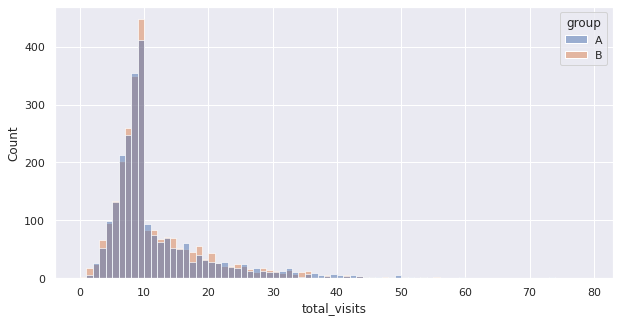

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=users, x='total_visits', hue='group', binwidth=1)
plt.show()

Диаграммы размаха:

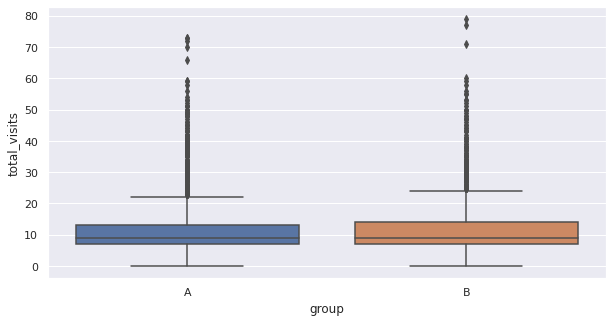

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

sns.boxplot(x='group', y='total_visits', data=users)
plt.show()

Распределения имеют длинные правые хвосты. В данном случае можно было бы использовать bootstrap для получения нормально распределенных данных, но воспользуемся им в следующем ДЗ, а пока применим обычные тесты проверки на нормальность, однородность дисперсий и равенство средних.

###Проверка распределений на нормальность

**H0**: распределение является нормальным <br>
**H1**: распределение не является нормальным

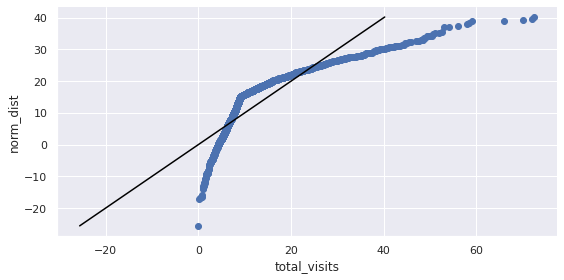

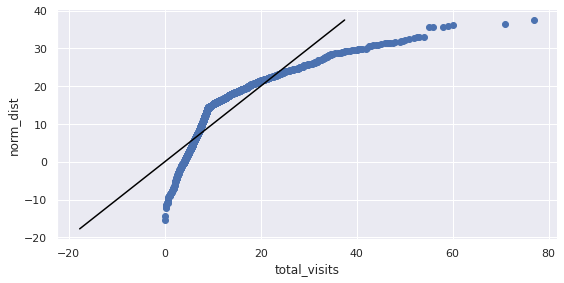

In [ ]:
tmp_a = pd.DataFrame(visits_group_a)
pplot(tmp_a, x='total_visits', y=norm, kind='qq', height=4, aspect=2, display_kws={'identity':True})

tmp_b = pd.DataFrame(visits_group_b)
pplot(tmp_b, x='total_visits', y=norm, kind='qq', height=4, aspect=2, display_kws={'identity':True})

plt.show()

Визуально распределения выглядят совсем не похожими на нормальные. Проведем формальный тест, чтобы убедиться в этом.

Воспользуемся **критерием Колмогорова-Смирнова** для проверки распределений на нормальность. <br>
Используем данный критерий, т.к. размеры наших выборок велики, а данный критерий как раз подходит для больших объемов выборок.<br>

In [ ]:
# normal distributions with the parameters of our data

loc_a, scale_a = visits_group_a.mean(), visits_group_a.std()
loc_b, scale_b = visits_group_b.mean(), visits_group_b.std()

norm_a = norm(loc=loc_a, scale=scale_a)
norm_b = norm(loc=loc_b, scale=scale_b)

In [ ]:
from scipy.stats import kstest

alpha = 0.05

p_value = kstest(visits_group_a, norm_a.cdf)[1]

print('Distribution A is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha], 
             p_value))

p_value = kstest(visits_group_b, norm_b.cdf)[1]

print('Distribution B is {}normal (p-value = {})'.
      format({True:'not ', False:''}[p_value < alpha],
             p_value))

Distribution A is not normal (p-value = 3.799587634898106e-136)
Distribution B is not normal (p-value = 6.880740610047225e-136)


Наши предположения оказались верны: **отвергаем нулевую гипотезу H0** о том, что распределение значений total_visits является нормальным (как для группы A, так и для группы B).

###Проверка равенства дисперсий

**H0**: Var(X1) = Var(X2) <br>
**H1**: Var(X1) != Var(X2)

В качестве критерия однородности используем **критерий Левена**, т.к. он менее чувствителен к отклонению распределения от нормального, чем другие критерии однородности (такие как F-критерий Фишера и критерий Бартлетта).

In [ ]:
from scipy.stats import levene
 
alpha = 0.05 

p_value = levene(visits_group_a, visits_group_b)[1]

print('{} the H0: Var(X1) = Var(X2) (p-value = {})\n'.
      format({True:'Reject', False:'Confirm'}[p_value < alpha],
             p_value))

Confirm the H0: Var(X1) = Var(X2) (p-value = 0.29144064110820345)



На основании полученного значения p-value мы **не можем отвергнуть нулевую гипотезу H0** о равенстве дисперсий групп A и B.

###Проверка статистической значимости различий 

Воспользуемся **U-критерием Манна-Уитни**. <br>
Он представляет непараметрическую альтернативу t-критерия для независимых выборок. Преимущество его состоит в том, что мы отказываемся от предположения нормальности распределения и одинаковых дисперсий. Кроме того, критерий Манна-Уитни использует сравнение рангов (номеров наблюдения в упорядоченной выборке), что позволяет ему быть устойчивым к выбросам.

In [ ]:
from scipy.stats import mannwhitneyu

alpha = 0.05

p_value = mannwhitneyu(visits_group_a, visits_group_b)[1]
 
print('Diffs is {}significant (p-value = {})'.
      format({False:'not ', True:''}[p_value < alpha],
             p_value)) 

Diffs is not significant (p-value = 0.4371611619684009)


Мы **не можем отвергнуть нулевую гипотезу**, следовательно, различия в средних количествах сессий для групп A и B вызваны лишь случайными причинами и статистически не значимы.<br><br>
Это значит, что **нововведение не оказало существенного влияния на среднее количество сессий пользователей**.

<a name="churn_ratio"></a>
#Отток пользователей

**Нулевая гипотеза**: <br>
H0 - различия в долях ушедших пользователей для групп A и B вызваны лишь случайными причинами <br>
**Альтернативная гипотеза**: <br>
H1 -  между долями ушедших пользователей для групп A и B действительно существуют значимые различия

In [ ]:
users.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group,total_visits
0,8,6630.000,0,0,0,8,A,8
1,13,6933.976,0,0,1,6,B,6
2,10,8261.976,1,10,1,8,B,18
3,4,5522.000,1,9,1,7,A,16
4,16,5075.976,1,6,0,8,B,14


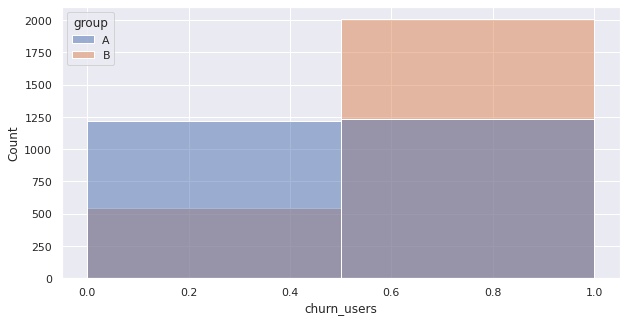

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=users, x='churn_users', hue='group', bins=2)
plt.show()

Распределение значений churn_users имеет вид распределения Бернулли<br>
Справка: случайная величина X имеет распределение Бернулли, если она принимает всего два значения: 1 и 0 с вероятностями p и q = 1-p соответственно.

Для оценки значимости различий будем использовать **two-proportion z-test**, с помощью которого можно определить, существуют ли различия между долями успеха в двух группах. В библиотеке statsmodels есть специальная функция для вычисления статистики и p-value данного теста: statsmodels.stats.proportion.proportions_ztest. Воспользуемся ей.

In [ ]:
churn_users_a = users.loc[users['group'] == 'A']['churn_users'].sum()
churn_users_b = users.loc[users['group'] == 'B']['churn_users'].sum()

print('Group A churn users: ', churn_users_a, sep='')
print('Group B churn users: ', churn_users_b, sep='')

Group A churn users: 1234
Group B churn users: 2004


In [ ]:
size_a = users.loc[users['group'] == 'A'].shape[0]
size_b = users.loc[users['group'] == 'B'].shape[0]

print('Group A size: ', size_a, sep='')
print('Group B size: ', size_b, sep='')

Group A size: 2451
Group B size: 2549


In [ ]:
print('Group A churn percentage: {:.2f}%'.format(churn_users_a / size_a * 100))
print('Group B churn percentage: {:.2f}%'.format(churn_users_b / size_b * 100))

Group A churn percentage: 50.35%
Group B churn percentage: 78.62%


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05

p_value = proportions_ztest(count=[churn_users_a, churn_users_b], 
                            nobs=[size_a, size_b])[1]
 
print('Diffs is {}significant (p-value = {})'.
      format({False:'not ', True:''}[p_value < alpha], p_value)) 

Diffs is significant (p-value = 3.524034717373751e-97)


Мы **отвергаем нулевую гипотезу** и таким образом получаем, что между долями ушедших пользователей для групп A и B действительно существуют значимые различия. <br><br>
Отток пользователей увеличился, то есть **нововведение оказало негативный эффект на обычный пользовательский поток: больше пользователей стало уходить**.

<a name="sample_size"></a>
#Расчет необходимого объема выборок

Метрика "Среднее значение metric_value"


Для определения требуемого объема выборки нам необходимы такие показатели как размер эффекта, статистическая значимость, статистическая мощность. 

Размер эффекта (Cohen's d) вычисляется по следующей формуле: <br>
mde = (mean_2 - mean_1) / std <br>
По формуле вычисляем размер эффекта на наших данных, а с помощью функции statsmodels.stats.power.TTestIndPower.solve_power() вычисляем требуемый размер выборки (берем статистическую значимость = 0.05 и статистическую мощность = 0.8, а соотношение размеров выборок = 1)

In [ ]:
from statsmodels.stats.power import TTestIndPower

effect = abs((metric_group_b.mean() - metric_group_a.mean()) / 
              metric_group_a.std())
alpha = 0.05
power = 0.8
ratio = 1

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, ratio=ratio, alpha=alpha)

print('Effect Size: %.3f' % effect)
print('Required Sample Size: %.3f' % result)

Effect Size: 0.254
Required Sample Size: 244.883


Для обнаружения эффекта 0.25 достаточно объема выборки около 250, что в 10 раз меньше нашего объема. При объеме ~2500 с большой мощностью можно обнаружить даже меньший эффект: 0.1 (см. график "Power of test" ниже). 

Метрика "Среднее количество сессий"

In [ ]:
effect = abs((visits_group_b.mean() - visits_group_a.mean()) / 
              visits_group_a.std())
alpha = 0.05
power = 0.8
ratio = 1

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, ratio=ratio, alpha=alpha)

print('Effect Size: %.3f' % effect)
print('Required Sample Size: %.3f' % result)

Effect Size: 0.026
Required Sample Size: 22974.647


Для обнаружения эффекта 0.026 необходимый размер выборки составляет ~23 000, что в несколько раз больше наших объемов выборок. Значит, мы могли не обнаружить статистическую значимость различий в средних количествах сессий из-за недостаточных размеров выборок. <br>
Мы могли бы произвести донабор пользователей (размеры DAU и WAU позволяют это сделать), но тогда пришлось бы продлить тест. <br>
Уменьшение среднего количества сессий в тестовой группе по сравнению с контрольной мало: ~2%, и донабор пользователей вместе с продлением теста может обойтись дороже, чем эти 2%, статистическую значимость которых мы стремимся обнаружить. Поэтому увеличивать выборки и продлевать тест стоит, только если количество сессий - очень важная метрика для нашей компании

Ниже приводится зависимость требуемого размера выборки от ожидаемого эффекта

In [ ]:
from statsmodels.stats.power import TTestIndPower

effect = [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
alpha = 0.05
power = 0.8
ratio = 1

analysis = TTestIndPower()

print('|----------------|----------------------|')
print('| Effect Size    | Required Sample Size |')
print('|----------------|----------------------|')

for eff in effect:
  result = analysis.solve_power(eff, power=power, ratio=ratio, alpha=alpha)
  print('| {:<15.2f}|'.format(eff), end='')
  print(' {:<21.2f}|'.format(result))

print('|----------------|----------------------|')

|----------------|----------------------|
| Effect Size    | Required Sample Size |
|----------------|----------------------|
| 0.01           | 156978.17            |
| 0.02           | 39245.26             |
| 0.05           | 6280.05              |
| 0.08           | 2453.73              |
| 0.10           | 1570.73              |
| 0.20           | 393.41               |
| 0.30           | 175.38               |
| 0.40           | 99.08                |
| 0.50           | 63.77                |
| 0.60           | 44.59                |
| 0.70           | 33.02                |
| 0.80           | 25.52                |
|----------------|----------------------|


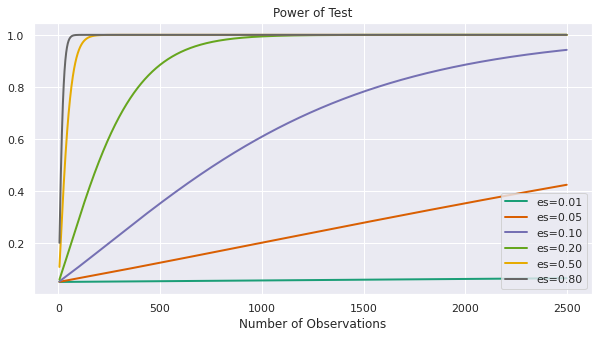

In [ ]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()
analysis.plot_power(nobs=np.arange(5, 2500), 
                    effect_size=np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8])) 
plt.show()

Метрика "Отток пользователей"

Для вычисления требуемого объема выборки при распределении Бернулли воспользуемся формулой <br>
n = (z_half_alpha + z_beta)^2 * (p1(1-p1) + p2(1-p2)) / (p1-p2)^2 <br>
**Source**: *Wang, H. and Chow, S.-C. 2007. Sample Size Calculation for Comparing Proportions. Wiley Encyclopedia of Clinical Trials*, pages 3-4, 3.1 Test for Equality.

In [ ]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as st

def sample_size_two_proportions(alpha, power, p1, p2):

  z_half_alpha = st.norm.ppf((1 - alpha) + alpha / 2)
  z_beta = st.norm.ppf(power)
  n = ((z_half_alpha + z_beta)**2 * 
       (p1 * (1 - p1) + p2 * (1 - p2)) / (p1 - p2)**2)
  
  return n

effect = abs(sm.stats.proportion_effectsize(churn_users_a / size_a, 
                                            churn_users_b / size_b))
alpha = 0.05
power = 0.8

res = sample_size_two_proportions(alpha, power, churn_users_a / size_a, 
                                  churn_users_b / size_b)
print('Effect Size: %.3f' % effect)
print('Required Sample Size: %.3f' % res)

Effect Size: 0.602
Required Sample Size: 41.053


Требуемый размер намного меньше размеров наших выборок.

<a name="conclusion"></a>
#Общий вывод 

Позитивный эффект нововведения: увеличение среднего показателя metric_value. <br>
Негативный эффект нововведения: значительно больший отток пользователей.<br>
Не изменилось: среднее количество сессий пользователей.<br><br>

A/B тест показал статистически значимые изменения по двум метрикам из трех. Как мы увидели выше, невозможность обнаружить статистически значимые различия для третьей метрики может быть обусловлена недостаточными объемами выборок. Если метрика "среднее количество сессий" пользователей действительно важна для компании, и даже небольшой процент изменения (2%) окажет влияние на принятие решения о дальнейшей судьбе нововведения, стоит раскатить тест на больший процент пользователей и продлить тест для сбора данных об этих пользователях. Однако для этого потребуются дополнительные ресурсы (как временные, так и в плане объемов, т.к. нам нужны большие выборки: порядка 23 000 пользователей в каждой).<br>
Если же для компании гораздо более важны первые две метрики или 2%, статистическую значимость которых мы стремимся обнаружить, не выглядят достаточным основанием для затраты дополнительных ресурсов на A/B тест, эксперимент можно завершать и принимать решение на основе полученных результатов.